---
# first in receipt prediction on multiple targets, fas data set 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime
os.getcwd()

'c:\\Users\\dscshap3808\\Documents\\data\\dlwisdom'

In [8]:

# path0 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2019 outbound\\'
# path1 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2020 outbound\\'
# # path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2021 outbound\\'
# path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\保乐力加_train\\outbound\\'
# %%time
# dfs0 = pd.DataFrame()
# for fname in os.listdir(path0):
#     if re.search(r'\.xls$', fname):
#         dfs0 = pd.concat(
#             [dfs0 ,pd.read_excel(path0 + fname)], 
#             axis = 0, 
#             ignore_index = True)

# dfs1 = pd.DataFrame()
# for fname in os.listdir(path1):
#     if re.search(r'\.xls$', fname):
#         dfs1 = pd.concat(
#             [dfs1 ,pd.read_excel(path1 + fname)], 
#             axis = 0, 
#             ignore_index = True)


# dfs2 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xls$', fname):
#         dfs2 = pd.concat(
#             [dfs2 ,pd.read_excel(path2 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# dfs2 = dfs2.dropna(axis =1 , how = 'all')
 
# # path+
# dfs = pd.DataFrame()
# for fname in os.listdir(path):
#     if re.search(r'\.xls$', fname):
#         dfs = pd.concat(
#             [dfs ,pd.read_excel(path + fname)], axis = 0, ignore_index = True)
# prc_in = pd.DataFrame(dfs)
# prc_in = prc_in.drop(['仓库城市','仓库编号','Unnamed: 7'], axis = 1)
# prc_in.columns = ['time', 'sku','name','code','quant']

# dfs3 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xlsx$', fname):
#         dfs3 = pd.concat(
#             [dfs3 ,pd.read_excel(path3 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
  
# # dfs2.head(200)

In [71]:
# df = pd.read_clipboard()
# df.to_csv('./fas_057_rh.csv', index = False, encoding='utf_8_sig')
df = pd.read_csv('./fas_057_rh.csv')
df = df.fillna(method = 'ffill')
df_test = pd.read_csv('./fas_inbhdr_test.csv')
df_test = df_test.fillna(method = 'ffill')
# df_test.columns = [re.sub(r'.+\.','',i) for i in df_test.columns]
df_test = df_test[df_test['RECEIPT_DATE'] > '2021-05-10']


In [72]:
df['CREATION_DATE_TIME_STAMP'].min()

'2017-09-11 03:24:56.000'

In [73]:
df.columns.columns = [i.upper() for i in df.columns.to_numpy()]
df_test.columns = [i.upper() for i in df_test.columns.to_numpy()]

In [74]:
def date_mutate(col, df):
    df[col + '_time'] = df[col].str.slice(11,-1).astype(str)
    df[col] = df[col].str.slice(0,10)
    df[col + '_2'] = [datetime.strptime(i,'%H:%M:%S.%f').strftime('%H%M%S') for i in df[col + '_time']]
    return df.head(1)

# df.columns[df.columns.str.contains(r'date|DATE')].to_numpy()
# df[df['receipt_id'].str.findall(r'(货)').apply(len) > 1]

for i in df.columns[df.columns.str.contains(r'date|DATE')].to_numpy():
    date_mutate(i, df)


first_df = df.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index();first_df


first_df = first_df.merge(
    df, 
    on = ['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2'], 
    how = 'inner')

# first_df2 = df.copy().groupby('CLOSE_DATE')[
#     ['receipt_id', 'receipt_date','total_lines', 'TOTAL_QTY']
#     ].sum().reset_index()

# first_df2.columns = ['CLOSE_DATE', 'ttl_line_cnt', 'ttl_qty_sum']

# first_df = first_df.merge(first_df2, how = 'inner', on = 'CLOSE_DATE')

# df[['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2']].sort_values(by = 'CREATION_DATE_TIME_STAMP')


for i in df_test.columns[df_test.columns.str.contains(r'date|DATE')].to_numpy():
    date_mutate(i, df_test)

df_test_first = df_test.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index()


df_test_first = df_test_first.merge(
    df_test, 
    on = ['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2'], 
    how = 'inner')

In [78]:
df[df['receipt_date'] == '2017-09-13']

,Internal_Receipt_num,warehouse,company,receipt_id,receipt_date,CLOSE_DATE,ARRIVED_DATE_TIME,CREATION_DATE_TIME_STAMP,total_lines,TOTAL_QTY,TOTAL_CONTAINERS,TOTAL_WEIGHT,receipt_date_time,receipt_date_2,CLOSE_DATE_time,CLOSE_DATE_2,ARRIVED_DATE_TIME_time,ARRIVED_DATE_TIME_2,CREATION_DATE_TIME_STAMP_time,CREATION_DATE_TIME_STAMP_2
6,12333,FAS,Solvay-SHANGHAI,205-82893856/320411889086,2017-09-13,2017-09-14,2017-09-14,2017-09-13,1,4.0,1,100.0,00:00:00.00,000000,13:03:11.09,130311,13:02:51.00,130251,01:22:11.00,012211
7,12336,FAS,Solvay-SHANGHAI,58014224641/127212017MI,2017-09-13,2017-09-14,2017-09-14,2017-09-13,2,60.0,2,140.0,00:00:00.00,000000,13:10:47.02,131047,13:10:21.00,131021,01:40:16.00,014016
8,12338,FAS,Solvay-SHANGHAI,58014224652/126922017MI,2017-09-13,2017-09-14,2017-09-14,2017-09-13,1,352.0,22,8800.0,00:00:00.00,000000,13:10:49.29,131049,13:07:09.00,130709,01:43:56.00,014356
9,12337,FAS,Solvay-SHANGHAI,58014224641/126782017MI,2017-09-13,2017-09-14,2017-09-14,2017-09-13,2,82.0,2,250.0,00:00:00.00,000000,13:10:50.06,131050,13:06:02.00,130602,01:42:16.00,014216
25,12334,FAS,Solvay-SHANGHAI,KKLUGOA140490,2017-09-13,2017-09-18,2017-09-18,2017-09-13,2,880.0,4,22000.0,00:00:00.00,000000,13:54:33.39,135433,13:31:20.00,133120,01:25:04.00,012504
26,12335,FAS,Solvay-SHANGHAI,MSCUKK886865,2017-09-13,2017-09-18,2017-09-18,2017-09-13,1,400.0,10,10000.0,00:00:00.00,000000,13:54:35.67,135435,13:33:50.00,133350,01:26:08.00,012608


In [76]:
df.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index();first_df

,CREATION_DATE_TIME_STAMP,CREATION_DATE_TIME_STAMP_2,Internal_Receipt_num,warehouse,company,receipt_id,receipt_date,CLOSE_DATE,ARRIVED_DATE_TIME,total_lines,TOTAL_QTY,TOTAL_CONTAINERS,TOTAL_WEIGHT,receipt_date_time,receipt_date_2,CLOSE_DATE_time,CLOSE_DATE_2,ARRIVED_DATE_TIME_time,ARRIVED_DATE_TIME_2,CREATION_DATE_TIME_STAMP_time
0,2017-09-11,032456,12318,FAS,Solvay-SHANGHAI,ZHUANGUAN/4512966525,2017-09-11,2017-09-14,2017-09-14,2,880.0,22,22000.00,00:00:00.00,000000,13:36:41.67,133641,13:30:40.00,133040,03:24:56.00
1,2017-09-12,050737,12321,FAS,Solvay-SHANGHAI,ZHUANGUAN/4512969246,2017-09-12,2017-09-18,2017-09-18,1,744.0,19,18600.00,00:00:00.00,000000,10:16:20.23,101620,10:12:39.00,101239,05:07:37.00
2,2017-09-13,012211,12333,FAS,Solvay-SHANGHAI,205-82893856/320411889086,2017-09-13,2017-09-14,2017-09-14,1,4.0,1,100.00,00:00:00.00,000000,13:03:11.09,130311,13:02:51.00,130251,01:22:11.00
3,2017-09-14,002402,12342,FAS,Pernod,20170914 CHANGE CODE-1,2017-09-14,2017-09-14,2017-09-14,1,6000.0,9,8000.00,00:00:00.00,000000,15:24:34.92,152434,15:19:44.00,151944,00:24:02.00
4,2017-09-15,014709,12353,FAS,Solvay-SHANGHAI,4512972142/71023208,2017-09-15,2017-09-22,2017-09-22,2,501.0,13,12525.00,00:00:00.00,000000,09:47:28.21,094728,09:41:57.00,094157,01:47:09.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,2021-04-25,075955,22156,FAS,Pernod,EGLV540100041630,2021-04-25,2021-04-27,2021-04-27,3,24192.0,18,18486.72,00:00:00.00,000000,05:59:32.16,055932,05:48:50.00,054850,07:59:55.00
889,2021-04-28,053557,22162,FAS,Pernod,227-50319861 M2100737,2021-04-28,2021-04-29,2021-04-29,2,1008.0,3,1290.24,00:00:00.00,000000,07:18:11.58,071811,07:16:57.00,071657,05:35:57.00
890,2021-04-29,051023,22163,FAS,Pernod,COSU6288760580,2021-04-29,2021-05-06,2021-05-06,1,10080.0,10,12516.00,00:00:00.00,000000,02:21:41.22,022141,02:19:05.00,021905,05:10:23.00
891,2021-04-30,045253,22168,FAS,Pernod,ONEYLIVB05481700,2021-04-30,2021-05-07,2021-05-07,1,16632.0,1,17269.56,00:00:00.00,000000,08:51:48.65,085148,08:50:06.00,085006,04:52:53.00


In [59]:
def data_mani(first_df, df):
    train_first = first_df.groupby(
        'CREATION_DATE_TIME_STAMP'
        ).agg({'receipt_id':['nunique'], 
        'total_lines': ['sum'], 
        'TOTAL_CONTAINERS': 'sum', 
        'TOTAL_WEIGHT':'sum',
        'TOTAL_QTY': ['sum'],
        'CREATION_DATE_TIME_STAMP_2': 'min' }).reset_index()
        
    train_full = df.groupby(
        'CREATION_DATE_TIME_STAMP'
        ).agg({'receipt_id':['nunique'], 
        'total_lines': ['sum'], 
        'TOTAL_CONTAINERS': 'sum', 
        'TOTAL_WEIGHT':'sum',
        'TOTAL_QTY': ['sum'],
        'CREATION_DATE_TIME_STAMP_2': 'max' }).reset_index()

    train_full.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']
    train_first.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']

    train_first.index= pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'], \
        yearfirst = True,  format='%Y-%m-%d')
    train_full.index = train_full['CREATION_DATE_TIME_STAMP']
    train_full.index = pd.DatetimeIndex(train_full.index)

    train_full['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_full['CREATION_DATE_TIME_STAMP'])
    train_first['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'])
    return train_first.reset_index(drop = True) , train_full.reset_index(drop = True)



In [60]:
train_first, train_full = data_mani(first_df, df)

In [70]:
train_full

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
0,2017-09-11,1,2,22,22000.00,880.0,032456
1,2017-09-12,9,30,96,850242.84,512046.0,084029
2,2017-09-13,6,9,41,41290.00,1778.0,014356
3,2017-09-14,11,49,140,121620.00,16690.0,071055
4,2017-09-15,4,16,36,96619.20,93797.0,034049
...,...,...,...,...,...,...,...
888,2021-04-25,6,9,55,113837.57,92622.0,080619
889,2021-04-28,1,2,3,1290.24,1008.0,053557
890,2021-04-29,1,1,10,12516.00,10080.0,051023
891,2021-04-30,6,7,26,116677.30,127932.0,045926


In [69]:
train_first

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
0,2017-09-11,1,2,22,22000.00,880.0,032456
1,2017-09-12,1,1,19,18600.00,744.0,050737
2,2017-09-13,1,1,1,100.00,4.0,012211
3,2017-09-14,1,1,9,8000.00,6000.0,002402
4,2017-09-15,1,2,13,12525.00,501.0,014709
...,...,...,...,...,...,...,...
888,2021-04-25,1,3,18,18486.72,24192.0,075955
889,2021-04-28,1,2,3,1290.24,1008.0,053557
890,2021-04-29,1,1,10,12516.00,10080.0,051023
891,2021-04-30,1,1,1,17269.56,16632.0,045253


<AxesSubplot:xlabel='container_sum', ylabel='qty'>

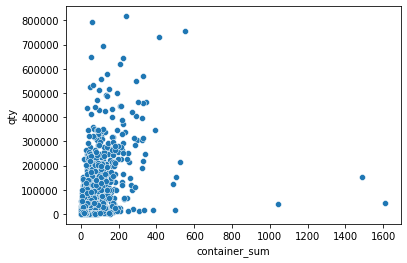

In [68]:
sns.scatterplot(x = 'container_sum', y  ='qty', data = train_full)

<AxesSubplot:xlabel='container_sum', ylabel='qty'>

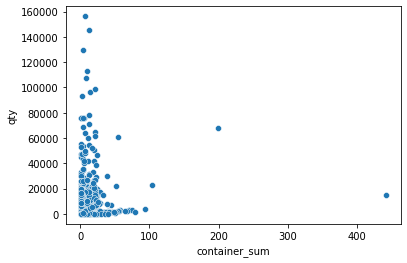

In [66]:
# train_first
sns.scatterplot(x = 'container_sum', y  ='qty', data = train_first)

---

In [6]:
# train_first.index= pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'], yearfirst = True,  format='%Y-%m-%d')
# train_first.pop('CREATION_DATE_TIME_STAMP')
# train_full.pop('CREATION_DATE_TIME_STAMP')
# train_full['qty'] = train_full['qty'].astype(int)
# train_first['qty'] = train_first['qty'].astype(int)
# train_first['qty2'] = train_full['qty'].to_numpy() ; train_first

# train_first = train_first.reset_index()
# train_first.drop(['qty2','CREATION_DATE_TIME_STAMP','creat_time'], axis =1) 

# sktime; timeseries only prediction on trainfull


In [7]:
# train_full.index = train_full['CREATION_DATE_TIME_STAMP']
# train_full.index = pd.DatetimeIndex(train_full.index);train_full.index
train_full_sktime = train_full.asfreq('D')
train_full_sktime = train_full_sktime.fillna(0);train_full_sktime


,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
CREATION_DATE_TIME_STAMP,,,,,,,
2017-09-11,2017-09-11 00:00:00,1.0,2.0,22.0,22000.00,880.0,032456
2017-09-12,2017-09-12 00:00:00,9.0,30.0,96.0,850242.84,512046.0,084029
2017-09-13,2017-09-13 00:00:00,6.0,9.0,41.0,41290.00,1778.0,014356
2017-09-14,2017-09-14 00:00:00,11.0,49.0,140.0,121620.00,16690.0,071055
2017-09-15,2017-09-15 00:00:00,4.0,16.0,36.0,96619.20,93797.0,034049
...,...,...,...,...,...,...,...
2021-05-03,0,0.0,0.0,0.0,0.00,0.0,0
2021-05-04,0,0.0,0.0,0.0,0.00,0.0,0
2021-05-05,0,0.0,0.0,0.0,0.00,0.0,0


In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.regression import ComposableTimeSeriesForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_percentage_error

x = train_full_sktime.drop(['qty', 'CREATION_DATE_TIME_STAMP', 'creat_time'], axis = 1)
y = train_full_sktime.loc[:,'qty']
x_train, x_test , y_train, y_test = temporal_train_test_split(x, y)
#
#  # fh = ForecastingHorizon(x_test, is_relative=False)
# forecaster = ComposableTimeSeriesForestRegressor(x = x_train, y = y_train)
# forecaster.fit(x_train ,y = y_train)
# y_pred = forecaster.predict(x_test)
# mean_absolute_percentage_error(y_test, y_pred)

forecaster = NaiveForecaster(sp = 21)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh )
mean_absolute_percentage_error(y_test, y_pred)



In [ ]:
from sktime.regression.interval_based import  TimeSeriesForestRegressor

In [ ]:
x_train.shape[1]

In [ ]:
# forecaster = TimeSeriesForestRegressor( )
# # fh = ForecastingHorizon(x_test, is_relative=False)
# forecaster.fit(X = x_train,  y = y_train)
# y_pred = forecaster.predict(x_test)
# mean_absolute_percentage_error(y_test, y_pred)

---

# prophet prepare

In [8]:
# train_full = train_full_sktime
train_full = train_full.asfreq('D')
train_full = train_full.fillna(0) 
train_first = train_first.asfreq('D')
train_first = train_first.fillna(0)
train_full['CREATION_DATE_TIME_STAMP'] = train_full.index
train_first['CREATION_DATE_TIME_STAMP'] = train_first.index


# train_full
train_full = train_full.reset_index(drop =True)
train_first = train_first.reset_index(drop =True)

train_fin = train_full.merge(train_first, 
    on = 'CREATION_DATE_TIME_STAMP', 
    how = 'outer',
    suffixes = ['_full', '_first'])
train_fin = train_fin.fillna(0);train_fin

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
CREATION_DATE_TIME_STAMP,,,,,,,
2017-09-11,2017-09-11,1.0,2.0,22.0,22000.00,880.0,032456
2017-09-12,2017-09-12,9.0,30.0,96.0,850242.84,512046.0,084029
2017-09-13,2017-09-13,6.0,9.0,41.0,41290.00,1778.0,014356
2017-09-14,2017-09-14,11.0,49.0,140.0,121620.00,16690.0,071055
2017-09-15,2017-09-15,4.0,16.0,36.0,96619.20,93797.0,034049
...,...,...,...,...,...,...,...
2021-05-03,2021-05-03,0.0,0.0,0.0,0.00,0.0,0
2021-05-04,2021-05-04,0.0,0.0,0.0,0.00,0.0,0
2021-05-05,2021-05-05,0.0,0.0,0.0,0.00,0.0,0


In [10]:
# train_full['creat_time_first']
train_fin['span_first'] = train_fin[
    'creat_time_first'
    ].str.slice(1,2).fillna(
        0
        ).astype(int, errors = 'ignore') + train_fin['creat_time_first'].str.slice(2,4).fillna(
            0
            ).astype(int, errors = 'ignore')/60*1 + 8

# # train_full['creat_time_x']
# train_first['span_full'] = train_first['creat_time_full'].str.slice(1,2).astype(int) + 
#     train_first['creat_time_full'].str.slice(2,4).astype(int)/60*1 + 8
train_first['span_first'] = train_first[
    'creat_time'
    ].str.slice(1,2).fillna(
        0
        ).astype(int, errors = 'ignore') + train_first['creat_time'].str.slice(2,4).fillna(
            0
            ).astype(int, errors = 'ignore')/60*1 + 8
train_first = train_first.drop('creat_time', axis = 1)

In [13]:
# from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split

x = train_first 
x['y'] = train_fin['qty_full']
# x['CREATION_DATE_TIME_STAMP'] = x.index
x_train, x_test = train_test_split(x, train_size = .75, shuffle = False, random_state = 52943)

cols = [i for i in x.columns if i not in ['y', 'CREATION_DATE_TIME_STAMP']]


In [13]:
%%time

from fbprophet import Prophet
# df = x[['CREATION_DATE_TIME_STAMP', 'qty']]
df_naiv = x_train 
df_naiv = df_naiv.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols]

m.fit(df_naiv)

from sklearn.metrics import mean_absolute_percentage_error
df_naiv_test = x_test
df_naiv_test = df_naiv_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
# m.predict(x_test)
mean_absolute_percentage_error(df_naiv_test['y'], m.predict(df_naiv_test)['yhat'])
# fig = m.plot_components(m.predict(x_test))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 3.17 s


In [ ]:
# m.plot_components(m.predict(df2))
# plt.show()

In [ ]:
# m.plot(m.predict(df2))
# plt.show()

---

# pseudo labeling

In [14]:
train_first['dif'] = train_first['qty'] - train_full['qty'] != 0
train_first['dif'] = [1 if i == True else 0 for i in train_first['dif']]

train_full['dif'] = train_first['qty'] - train_full['qty'] != 0
train_full['dif'] = [1 if i == True else 0 for i in train_full['dif']]

# train_full['diff'] = train_full['qty_x'] - train_full['qty_y'] ==  0
# train_full['diff'] = [1 if i == True else 0 for i in train_full['diff']]
# train_full = train_full.asfreq('D')

In [15]:
x = train_first.drop('y', axis  =1 )
x_train, x_test = train_test_split(x, train_size = .75, shuffle = False, random_state = -1)


In [16]:
%%time
from fbprophet import Prophet 
df_lb = x_train 

## qty_x s是最终预测值, 所以要drop
cols_lb = [i for i in df_lb.columns 
    if i not in ['dif', 'CREATION_DATE_TIME_STAMP']]

# df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'dif': 'y'}, axis = 1)
m = Prophet(daily_seasonality=True) 

"""
0.12379144878303337 daily_seasonality=True; empty 0.12318682390845224
"""


[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)

# ?mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import accuracy_score

# x_test1 = x_test.drop(['dif'], axis =1 )
x_test1 = x_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'dif': 'y'}, axis = 1)
 
# m.predict(x_test)
forecast = m.predict(x_test1)
mean_absolute_error(x_test1['y'], m.predict(x_test1)['yhat'])
# fig = m.plot_components(m.predict(x_test))

Wall time: 11.1 s


0.12379144878303337

In [17]:
# # %%warning = False
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)
 

In [18]:
lb_prophet_result = pd.DataFrame(forecast['yhat'])
lb_prophet_result['abs_diff'] = np.abs(forecast['yhat'] - .5)
lb_prophet_result.sort_values('abs_diff').iloc[0,0]

0.7434468844249535

In [19]:
acc_score_data  = [1 if i>=lb_prophet_result['yhat'].mean() \
    else 0 for i in forecast['yhat']]

acc_score_data1 = [1 if i>=lb_prophet_result.sort_values('abs_diff').iloc[0,0] \
    else 0 for i in forecast['yhat']]
    
acc_score_data2 = [1 if i>lb_prophet_result['yhat'].std() \
    else 0 for i in forecast['yhat']]

# mean_absolute_error(x_test1['y'], m.predict(x_test1)['yhat'])
[accuracy_score(x_test1['y'],i) for i in [acc_score_data, acc_score_data1, acc_score_data2]]


[0.9161676646706587, 0.9161676646706587, 0.9161676646706587]

----
## try h2o predict qty

In [23]:
x_train2 = x_train[x_train['dif'] == 1] 
x_test2 = x_test[x_test['dif'] == 1];len(x_test2)
x_train2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[0:len(x_train2), :]['qty']
x_test2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[len(x_train2):, :]['qty'];x_train2

<ipython-input-23-dd408b05bf4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[0:len(x_train2), :]['qty']
<ipython-input-23-dd408b05bf4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[len(x_train2):, :]['qty'];x_train2


,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,span_first,dif,qty_tar
1,2017-09-12,1.0,1.0,19.0,18600.00,744.0,13.116667,1,512046.0
2,2017-09-13,1.0,1.0,1.0,100.00,4.0,9.366667,1,1778.0
3,2017-09-14,1.0,1.0,9.0,8000.00,6000.0,8.400000,1,16690.0
4,2017-09-15,1.0,2.0,13.0,12525.00,501.0,9.783333,1,93797.0
7,2017-09-18,1.0,1.0,1.0,0.00,600.0,8.966667,1,122508.0
...,...,...,...,...,...,...,...,...,...
990,2020-05-28,1.0,5.0,10.0,1450.00,148.0,14.850000,1,276520.0
991,2020-05-29,1.0,6.0,15.0,15487.20,8310.0,12.616667,1,75476.0
994,2020-06-01,1.0,1.0,2.0,9651.44,6470.0,10.850000,1,78856.0
996,2020-06-03,1.0,2.0,4.0,500.00,8.0,8.850000,1,552.0


In [24]:
import h2o
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\dscshap3808\Miniconda3\envs\siming\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\DSCSHA~1\AppData\Local\Temp\tmp3gyun6d8
  JVM stdout: C:\Users\DSCSHA~1\AppData\Local\Temp\tmp3gyun6d8\h2o_dscshap3808_started_from_python.out
  JVM stderr: C:\Users\DSCSHA~1\AppData\Local\Temp\tmp3gyun6d8\h2o_dscshap3808_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,3 months and 4 days
H2O_cluster_name:,H2O_from_python_dscshap3808_m8s28w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.465 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [25]:
cols_h2o = [i for i in x_train2.columns.to_numpy() if i not in 'qty_tar']

# Import the prostate dataset
h2o_df = h2o.H2OFrame(x_train2)
# Split the data giving the training dataset 75% of the data
train,test = h2o_df.split_frame(ratios=[0.75])

# Build an Isolation forest model
model = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 500)
model.train(training_frame=train,x =cols_h2o)

# Calculate score
score = model.predict(test)
result_pred = score["predict"]

# Predict the leaf node assignment
ln_pred = model.predict_leaf_node_assignment(test, "Path")

Parse progress: |█████████████████████████████████████████████████████████| 100%


C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\h2o\estimators\estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [dif, id]
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


In [42]:
score_train = model.predict(train)
forest_pred_trai = pd.concat([score_train['predict'].as_data_frame(),\
    result_pred.as_data_frame() ], axis = 0).reset_index()
forest_pred_test = model.predict(h2o.H2OFrame(x_test2))

isolationforest prediction progress: |████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


In [44]:
train.as_data_frame()

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,span_first,dif,qty_tar
0,1505260800000,1,1,1,100.00,4,9.366667,1,1778
1,1505347200000,1,1,9,8000.00,6000,8.400000,1,16690
2,1505433600000,1,2,13,12525.00,501,9.783333,1,93797
3,1505692800000,1,1,1,0.00,600,8.966667,1,122508
4,1505779200000,1,1,1,1375.00,55,9.083333,1,18459
...,...,...,...,...,...,...,...,...,...
503,1590105600000,1,2,2,1000.00,40,9.483333,1,11413
504,1590364800000,1,31,46,4240.00,1550,16.166667,1,3670
505,1590537600000,1,2,18,0.00,720,9.000000,1,278830
506,1590969600000,1,1,2,9651.44,6470,10.850000,1,78856


In [64]:
train.as_data_frame().append(score_train.as_data_frame)

NameError: name 'train' is not defined

In [38]:
score2

predict,mean_length
0.21833,4.796
0.285029,4.518
0.21881,4.794
0.21785,4.798
0.203935,4.856
0.256238,4.638
0.179463,4.958
0.230326,4.746
0.547985,3.422
0.194338,4.896


In [27]:
# Generate predictions on a test set (if necessary):
pred = dl.predict(test)

NameError: name 'dl' is not defined

In [28]:
sult = pd.concat([test.as_data_frame()['qty_tar'], pred.as_data_frame()], axis = 1)

NameError: name 'pred' is not defined

In [586]:
sult

,qty_tar,predict
0,512046,70588.954
1,557054,118090.120
2,269974,75245.898
3,227126,49231.764
4,1556,110033.479
...,...,...
148,137628,101245.807
149,66792,94210.784
150,627,108667.831
151,174614,93680.845


In [587]:
mean_absolute_percentage_error(sult['qty_tar'], sult['predict'])

0.9815690588439775

In [ ]:
x_train2 = x_train2.reset_index()
x_test2 = x_test2.reset_index()
x_train2['labels'] = forest_pred_trai['predict'] 
x_test2['labels'] = forest_pred_test.as_data_frame()['predict']

In [625]:
predictors = [i for i in x_train2.columns.to_numpy() if i not in 'qty_tar']
response = 'qty_tar'
# Import the prostate dataset
h2o_df = h2o.H2OFrame(x_train2)
# Split the data giving the training dataset 75% of the data
train,test = h2o_df.split_frame(ratios=[0.75])

dl = H2ODeepLearningEstimator(distribution="AUTO",
                               hidden=[300,300],
                               epochs=600,
                               train_samples_per_iteration=-1,
                               reproducible=True,
                               activation="Rectifierwithdropout",
                               single_node_mode=False,
                               balance_classes=False,
                               force_load_balance=False,
                               seed=707,
                               tweedie_power=1.5,
                               score_training_samples=0,
                               score_validation_samples=0,
                               score_each_iteration = True,
                               stopping_rounds=0)
dl.train(x=predictors,
         y=response,
          training_frame= train,
          validation_frame = test)

# Eval performance:
perf = dl.model_performance();perf


Parse progress: |█████████████████████████████████████████████████████████| 100%


C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\h2o\estimators\estimator_base.py:200: RuntimeWarning:

Dropping bad and constant columns: [dif, id]



deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [626]:
perf


ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 14685154500.84614
RMSE: 121182.3192584056
MAE: 89018.82023171475
RMSLE: 2.1365093452549284
Mean Residual Deviance: 14685154500.84614


In [634]:
test_lb_qty_test2 = dl.predict(test).as_data_frame()

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [635]:
test_lb_qty_test2

,predict
0,99565.780
1,88117.935
2,89499.800
3,95550.174
4,75516.070
...,...
158,118838.615
159,116225.289
160,91693.632
161,114525.696


In [ ]:
mean_absolute_percentage_error(sult['qty_tar'], sult['predict'])

----
## Darts

In [20]:
df_lb , x_test1 

"""
the dataframes are taken from fbprophet model, 
no need to split anyway.
"""

'\nthe dataframes are taken from fbprophet model, \nno need to split anyway.\n'

In [40]:
df_lb

,ds,id,line_sum,container_sum,weight,qty,span_first,y
0,2017-09-11,1.0,2.0,22.0,22000.0,880.0,11.400000,0
1,2017-09-12,1.0,1.0,19.0,18600.0,744.0,13.116667,1
2,2017-09-13,1.0,1.0,1.0,100.0,4.0,9.366667,1
3,2017-09-14,1.0,1.0,9.0,8000.0,6000.0,8.400000,1
4,2017-09-15,1.0,2.0,13.0,12525.0,501.0,9.783333,1
...,...,...,...,...,...,...,...,...
996,2020-06-03,1.0,2.0,4.0,500.0,8.0,8.850000,1
997,2020-06-04,1.0,1.0,23.0,16236.0,10824.0,9.983333,1
998,2020-06-05,0.0,0.0,0.0,0.0,0.0,8.000000,0
999,2020-06-06,0.0,0.0,0.0,0.0,0.0,8.000000,0


In [41]:
from darts import TimeSeries

series_train = TimeSeries.from_dataframe(df_lb, 
       time_col = 'ds', 
       value_cols ='y')
series_test = TimeSeries.from_dataframe(x_test1, 
       time_col = 'ds', 
       value_cols =  'y')
series_train_cov = TimeSeries.from_dataframe(df_lb,\
       'ds',
       ['id', 'line_sum', 'container_sum', 'weight', 'qty', 'span_first'])
series_test_cov = TimeSeries.from_dataframe(x_test1, 
       'ds', 
       ['id', 'line_sum', 'container_sum', 'weight', 'qty', 'span_first'] )

,ds,id,line_sum,container_sum,weight,qty,span_first,y
0,2017-09-11,1.0,2.0,22.0,22000.0,880.0,11.400000,0
1,2017-09-12,1.0,1.0,19.0,18600.0,744.0,13.116667,1
2,2017-09-13,1.0,1.0,1.0,100.0,4.0,9.366667,1
3,2017-09-14,1.0,1.0,9.0,8000.0,6000.0,8.400000,1
4,2017-09-15,1.0,2.0,13.0,12525.0,501.0,9.783333,1
...,...,...,...,...,...,...,...,...
1330,2021-05-03,0.0,0.0,0.0,0.0,0.0,8.000000,0
1331,2021-05-04,0.0,0.0,0.0,0.0,0.0,8.000000,0
1332,2021-05-05,0.0,0.0,0.0,0.0,0.0,8.000000,0
1333,2021-05-06,0.0,0.0,0.0,0.0,0.0,8.000000,0


In [57]:
ful_span = TimeSeries.from_dataframe(df_lb.append(x_test1), \
    'ds', 
    value_cols = 'y')
ful_span_cov = TimeSeries.from_dataframe(df_lb.append(x_test1), \
    'ds', 
    ['id', 'line_sum', 'container_sum', 'weight', 'qty', 'span_first'] )

In [42]:
from darts.models import *
md1_bert = NBEATSModel(input_chunk_length=31, \
    output_chunk_length=15, n_epochs=5, random_state=43)
    
# md2_lstm = BlockRNNModel(model='LSTM', \
#     input_chunk_length=12, output_chunk_length=6, n_epochs=5, random_state=43)


 > ## *Past Covariates denote time series whose past values are known at prediction time. These are usually things that have to be measured or observed. * Future Covariates denote time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts.*
> 
> 
 > ## input_chunk_length: this is the length of the lookback window of the model; so each output will be computed by the model by reading the previous input_chunk_length points. 

In [36]:
%%time
md1_bert.fit(series = series_train, \
    past_covariates = series_train_cov,
    verbose=True)

[2021-08-24 14:30:29,688] INFO | darts.models.torch_forecasting_model | Train dataset contains 956 samples.
[2021-08-24 14:30:29,688] INFO | darts.models.torch_forecasting_model | Train dataset contains 956 samples.
INFO:darts.models.torch_forecasting_model:Train dataset contains 956 samples.
[2021-08-24 14:30:29,862] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-24 14:30:29,862] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
INFO:darts.models.torch_forecasting_model:Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/5 [00:00<?, ?it/s]

Wall time: 1min 7s


In [38]:
%%time
backtest_bert = md1_bert.historical_forecasts(series_train,\
    past_covariates = series_train_cov,
    start = .75,
    retrain = False)

# backtest_cov = model_cov.historical_forecasts(series_air_scaled,
#                                               past_covariates=air_covariates,
#                                               start=0.6,
#                                               forecast_horizon=12,
#                                               stride=1,
#                                               retrain=False,
#                                               verbose=True)


Wall time: 20.2 s


In [65]:
backtest_bert.values()

array([[  8.58003488],
       [ 16.75006646],
       [ -7.71201114],
       [ 19.46110313],
       [ 12.88660144],
       [ 28.29548925],
       [ 20.85115673],
       [  5.7885872 ],
       [  3.74193627],
       [  1.9756352 ],
       [ -5.39893731],
       [ -3.82845924],
       [  8.08884992],
       [ -3.57432284],
       [  4.51135072],
       [ 12.48935999],
       [ 17.10340229],
       [  2.95315206],
       [ -6.86915419],
       [  5.87270726],
       [ -0.13573028],
       [ 32.73669842],
       [ 28.48003049],
       [ -9.44669531],
       [ 21.75007443],
       [  8.8699816 ],
       [ -8.8958137 ],
       [ -1.46431506],
       [ -0.40100006],
       [ -3.77870952],
       [ -2.47703573],
       [  1.24799463],
       [  3.20450235],
       [  0.45291843],
       [ 24.27563614],
       [ -0.56996219],
       [ 10.20096776],
       [ -0.02575219],
       [  1.7723841 ],
       [  4.92180411],
       [ -9.43878706],
       [ 24.11984083],
       [ -0.59175919],
       [-24

In [27]:
%%time
train_pred_bert = md1_bert.predict(n = 334 , 
    past_covariates = series_train_cov,
    # future_covariates = series_test_cov
    )
train_pred_bert.values()

In [85]:
from darts.metrics import mape
mean_absolute_error(train_pred_bert.values(), series_test.values())

20.53783696504374

## lSTM in darts

In [37]:
%%time
LSTM_darts = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=7,
    n_epochs=5,
    optimizer_kwargs={'lr': 1e-3},
    model_name='lstm_RNN',
    log_tensorboard=True,
    random_state=42,
    # training_length=20,
    input_chunk_length=31,
    force_reset=True
)
LSTM_darts.fit(series_train,
             future_covariates=series_train_cov,
            #  val_series=series_test,
            #  val_future_covariates=series_test_cov,
             verbose=True)

[2021-08-24 14:32:34,355] INFO | darts.models.torch_forecasting_model | Train dataset contains 977 samples.
[2021-08-24 14:32:34,355] INFO | darts.models.torch_forecasting_model | Train dataset contains 977 samples.
INFO:darts.models.torch_forecasting_model:Train dataset contains 977 samples.
[2021-08-24 14:32:34,367] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-24 14:32:34,367] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
INFO:darts.models.torch_forecasting_model:Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/5 [00:00<?, ?it/s]

Wall time: 23.1 s


In [62]:
np.set_printoptions(suppress=True)
lstm_pred_test = LSTM_darts.predict(n = 334, future_covariates = ful_span_cov).values()

In [67]:
acc_score_data  = [1 if i>=lstm_pred_test.mean() \
    else 0 for i in lstm_pred_test]

# acc_score_data1 = [1 if i>=lstm_pred_test.sort_values() \
#     else 0 for i in forecast['yhat']]
    
# acc_score_data2 = [1 if i>lb_prophet_result['yhat'].std() \
#     else 0 for i in forecast['yhat']]

# mean_absolute_error(x_test1['y'], m.predict(x_test1)['yhat'])
# [accuracy_score(x_test1['y'],i) for i in [acc_score_data, acc_score_data1, acc_score_data2]]
accuracy_score(x_test1['y'],acc_score_data) 

0.9131736526946108

In [86]:
lstm_plt = x_test1.copy()
lstm_plt['y_pred'] = lstm_pred_test

In [109]:
import plotly.express as ex
fig = ex.scatter(data_frame=lstm_plt, x = 'ds', y = 'y')
fig.add_scatter(x = lstm_plt['ds'],  y = lstm_plt['y_pred'])
fig.show()

In [127]:
# import altair as alt
# brush = alt.selection_interval()
# alt.Chart(lstm_plt).mark_point().encode(
#     x='ds',
#     y='y'
# ).add_selection(
#     brush
# )
 

In [136]:
# min(abs(lstm_plt['y_pred'] - .5))

lstm_plt['abs_diff'] = np.abs(lstm_plt['y_pred'] - .5)
lstm_plt.sort_values('abs_diff')

,ds,id,line_sum,container_sum,weight,qty,span_first,y,y_pred,abs_diff
1141,2020-10-26,1.0,1.0,1.0,1.00,1.0,10.683333,1,0.565032,0.065032
1243,2021-02-05,1.0,1.0,1.0,13.70,12.0,11.750000,0,0.733695,0.233695
1152,2020-11-06,1.0,3.0,11.0,8603.77,14364.0,14.533333,1,0.774042,0.274042
1047,2020-07-24,1.0,3.0,17.0,11534.34,52440.0,10.433333,0,0.805019,0.305019
1129,2020-10-14,1.0,1.0,13.0,8757.00,7560.0,9.200000,1,0.851866,0.351866
...,...,...,...,...,...,...,...,...,...,...
1200,2020-12-24,1.0,2.0,21.0,17050.90,16404.0,10.216667,1,1.099847,0.599847
1094,2020-09-09,1.0,1.0,1.0,25.00,1.0,10.483333,1,1.109431,0.609431
1096,2020-09-11,1.0,1.0,10.0,7476.00,7200.0,15.533333,1,1.111652,0.611652
1114,2020-09-29,1.0,12.0,13.0,0.00,13.0,9.016667,1,1.268981,0.768981


In [151]:
pred_1_lable1 = [1 if i> 0.565032 else 0 for i in lstm_plt['y_pred']]
# lstm_plt['y_pred']
pred_1_lable2 = [1 if i> lstm_plt['y_pred'].mean() else 0 for i in lstm_plt['y_pred']]

In [152]:
from sklearn.metrics import mean_absolute_percentage_error
[accuracy_score(lstm_plt['y'], pred_1_lable1),
accuracy_score(lstm_plt['y'], pred_1_lable2)]

[0.9131736526946108, 0.9131736526946108]

In [154]:


# series.plot(label='data')
# for i, m in enumerate(berkets):
#     err = mape(backtests[i], series)
#     backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

# plt.title('Backtests with 3-months forecast horizon')
# plt.legend()

---

## qty prediction, filter data which not 1

In [478]:
x_train2 = x_train[x_train['dif'] == 1] 
x_test2 = x_test[x_test['dif'] == 1];len(x_test2)
x_train2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[0:len(x_train2), :]['qty']
x_test2['qty_tar'] = train_full[train_full['dif'] == 1].iloc[len(x_train2):, :]['qty']

<ipython-input-478-ec36bd9eb2ef>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-478-ec36bd9eb2ef>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [479]:
[len(x_train2),len(x_test2)]

[652, 180]

In [485]:
df_2_all = pd.DataFrame(pd.concat([x_train2, x_test2], axis = 0)).reset_index(); df_2_all

index                                int64
CREATION_DATE_TIME_STAMP    datetime64[ns]
id                                 float64
line_sum                           float64
container_sum                      float64
weight                             float64
qty                                float64
span_first                         float64
dif                                  int64
qty_tar                            float64
dtype: object

In [487]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

tran3 = ColumnTransformer([
        ('somename', StandardScaler(), ['weight', 'qty', 'qty_tar'])
    ])
tran3.fit(df_2_all[['weight', 'qty', 'qty_tar']])

df_2_all[['weight', 'qty',  'qty_tar']] = pd.DataFrame(
    tran3.fit_transform(df_2_all[['weight', 'qty', 'qty_tar']])

) 

In [449]:
# tran2.fit(x_train2[['weight', 'qty', 'span_first']])
# tran2.transform(x_test2[['weight', 'qty', 'span_first']])

df_2_all =df_2_all.fillna(0)
x_train2 = df_2_all.iloc[0:652,:]
x_test2 = df_2_all.iloc[652:,:]

In [499]:
from fbprophet import Prophet 
df_lb = x_train2

## qty_x s是最终预测值, 所以要drop
cols_lb = [i for i in df_lb.columns 
    if i not in ['qty_tar', 'CREATION_DATE_TIME_STAMP']]

# df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_tar': 'y'}, axis = 1)
m = Prophet(daily_seasonality=True)
[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)


# ?mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import accuracy_score

# x_test1 = x_test.drop(['dif'], axis =1 )
x_test1 = x_test2.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_tar': 'y'}, axis = 1)
 
# m.predict(x_test)
forecast = m.predict(x_test1)
mean_absolute_percentage_error(x_test1['y'], m.predict(x_test1)['yhat'])
# fig = m.plot_components(m.predict(x_test))

1.5763984683125858

---
# cross validation on prophet

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, initial='365 days', period='31 days', horizon = '180 days')


In [ ]:
df_cv = pd.DataFrame(df_cv);df_cv

In [ ]:
sns.scatterplot(data = df_cv, x = 'ds', y = 'yhat')

In [ ]:
performance_metrics(df_cv).sort_values('mae')

## Tunning paras

In [ ]:
from fbprophet import Prophet 
df_lb = x_train 
cols_lb = [i for i in df_lb.columns 
    if i not in ['diff','qty_x','creat_time_x','creat_time_y','CREATION_DATE_TIME_STAMP']]

df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'diff': 'y'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)

In [ ]:
%%Time
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.01,  0.5],
    'seasonality_prior_scale': [0.01, 0.1],
}
 

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    [m.add_regressor(i) for i in cols_lb]
    m.fit(df_lb)
    df_cv = cross_validation(m, 
        initial='365 days', period='31 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
df_lb

In [ ]:
x_test1 = x_test.drop(['creat_time_x','creat_time_y', 'qty_x', 'diff'], axis =1 )
x_test1 = x_test1.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1)
x_test1['y'] = 0
m.predict(x_test1)
mean_absolute_error(x_test['diff'], m.predict(x_test1)['yhat'])

In [ ]:
values = m.predict(x_test1)['yhat']
labels = [1 if i>.5 else 0 for i in values]

In [ ]:
x_test['pred_labels'] = labels;x_test


In [ ]:
accuracy_score(x_test['diff'], x_test['pred_labels'])

In [ ]:
x_train

In [ ]:
# qty_x is target
from fbprophet import Prophet 
df_value = x_train 
df_value = df_value.drop(['creat_time_x','creat_time_y'], axis =1 )

df_value = df_value.rename({
    'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_x': 'y', 'diff':'pred_labels'
    }, axis = 1)

    
cols_value = [i for i in df_value.columns 
    if i not in ['y', 'ds', 'pred_labels']]

m = Prophet()
[m.add_regressor(i) for i in cols_value]

m.fit(df_value)

In [ ]:
df_value

In [ ]:
x_test_fin = x_test.drop(['creat_time_x','creat_time_y', 'qty_x', 'diff'], axis =1 )
 
x_test_fin = x_test_fin.rename({'CREATION_DATE_TIME_STAMP' : 'ds'}, axis = 1);
x_test_fin

In [ ]:

# m.predict(x_test_fin)
mean_absolute_percentage_error(x_test['qty_x'], m.predict(x_test_fin)['yhat'])

# aaa

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn import model_selection
cv_split = model_selection.ShuffleSplit(
    n_splits = 6, 
    test_size = .25, 
    # max_train_size = .75
    )
alg1 = Lasso()

cv_results_1 = model_selection.cross_validate(
    alg1, 
    train_first.drop(['qty2','CREATION_DATE_TIME_STAMP','creat_time'], axis =1) , train_first['qty2'].to_numpy(), 
    cv  = cv_split, scoring='neg_mean_absolute_percentage_error')


cv_results_1['test_score'].mean()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
alg2 = RandomForestRegressor(n_estimators = 34, 
        max_depth = 61,
        min_samples_split = 3, 
        min_samples_leaf=4, 
        # max_leaf_nodes = 31
        )
cv_results_2 = model_selection.cross_validate(
        alg2, 
        train_first, 
        train_full['qty'], 
        cv  = cv_split, scoring='neg_mean_absolute_percentage_error')
cv_results_2['test_score'].mean()

In [ ]:
alg2.fit(train_first,train_full['qty']).predict(train_first)

In [ ]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (891, 891, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'identity', 
    solver = 'adam', learning_rate = 'adaptive')
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()

In [ ]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (1120, 850, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'relu', 
    solver = 'adam', 
    learning_rate = 'adaptive',
    warm_start = True,
    early_stopping = True
    )
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()